# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [51]:
!ls -al /input

total 8308
drwxr-xr-x   4 root root    6144 Apr 29 00:27 .
drwxr-xr-x 139 root root    4096 Aug 16 16:16 ..
drwxr-xr-x   2 root root 6137856 Apr 28 19:01 img_align_celeba
drwxr-xr-x   2 root root 2365440 Apr 28 18:57 mnist


In [52]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

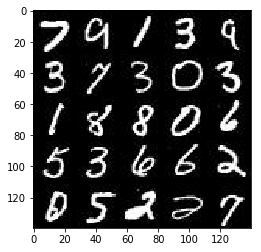

In [53]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

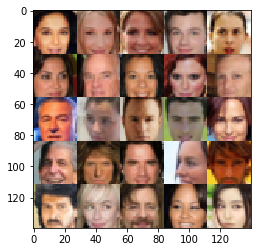

In [54]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [56]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_inputs = tf.placeholder(
        tf.float32, 
        (None, image_height, image_width, image_channels),
        name='real_inputs'
    )
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    lrate = tf.placeholder(tf.float32, name='lrate')
    return real_inputs, z_inputs, lrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [73]:
def discriminator(images, reuse=False, alpha=0.1, kernel=5, filters=64):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Input layer is 28x28x3
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(
            images, filters, kernel, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(
            relu1, filters*2, kernel, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(
            relu2, filters*4, kernel, strides=1, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 7*7*filters*4))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [74]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, kernel=5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(
            x1, 256, kernel, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(
            x2, 128, kernel, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(
            x3, out_channel_dim, kernel, strides=1, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)






Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [67]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gen_model, reuse=True)
    
    ones_like_real = tf.ones_like(d_model_real)
    one_sided_smooth_labels = tf.multiply(
        ones_like_real,
        tf.random_uniform((1,), minval=0.8, maxval=1.)
    )

    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=one_sided_smooth_labels
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [68]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [69]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [70]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps=0
    
    # TODO: Build Model
    image_channels = 3 if data_image_mode == 'RGB' else 1
    image_height, image_width = data_shape[1], data_shape[2]
    real_inputs, z_inputs, lrate = model_inputs(
        image_width, image_height, image_channels, z_dim)
        
    d_loss, g_loss = model_loss(real_inputs, z_inputs, image_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lrate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images = 2 * batch_images
                
                batch_z = np.random.uniform(-1 ,1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    real_inputs: batch_images,
                    z_inputs: batch_z,
                    lrate: learning_rate
                })
                
                # Double the number of trains to generator
                _ = sess.run(g_opt, feed_dict={
                    z_inputs: batch_z,
                    real_inputs: batch_images,
                    lrate: learning_rate
                })
                
                
                if steps % 10 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Sum Loss: {:.4f}".format(train_loss_g+train_loss_d))
                
                if steps % 100 == 0:
                    show_generator_output(
                        sess,
                        25,
                        z_inputs,
                        image_channels,
                        data_image_mode
                    )
                  
        show_generator_output(sess, 25, z_inputs, image_channels, data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6106... Generator Loss: 4.2500 Sum Loss: 4.8606
Epoch 1/2... Discriminator Loss: 0.2946... Generator Loss: 5.3557 Sum Loss: 5.6502
Epoch 1/2... Discriminator Loss: 0.5450... Generator Loss: 16.3648 Sum Loss: 16.9098
Epoch 1/2... Discriminator Loss: 0.4339... Generator Loss: 5.2674 Sum Loss: 5.7013
Epoch 1/2... Discriminator Loss: 0.3127... Generator Loss: 13.6692 Sum Loss: 13.9819
Epoch 1/2... Discriminator Loss: 0.4063... Generator Loss: 6.8084 Sum Loss: 7.2147
Epoch 1/2... Discriminator Loss: 0.4242... Generator Loss: 9.3382 Sum Loss: 9.7624
Epoch 1/2... Discriminator Loss: 0.3250... Generator Loss: 4.3530 Sum Loss: 4.6780
Epoch 1/2... Discriminator Loss: 0.5062... Generator Loss: 10.0023 Sum Loss: 10.5086
Epoch 1/2... Discriminator Loss: 0.3683... Generator Loss: 1.7012 Sum Loss: 2.0695


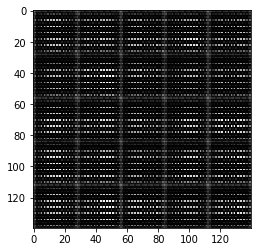

Epoch 1/2... Discriminator Loss: 0.5075... Generator Loss: 5.0054 Sum Loss: 5.5129
Epoch 1/2... Discriminator Loss: 0.3366... Generator Loss: 6.3590 Sum Loss: 6.6955
Epoch 1/2... Discriminator Loss: 0.1838... Generator Loss: 4.9354 Sum Loss: 5.1192
Epoch 1/2... Discriminator Loss: 0.7583... Generator Loss: 10.0097 Sum Loss: 10.7680
Epoch 1/2... Discriminator Loss: 0.1704... Generator Loss: 9.9660 Sum Loss: 10.1364
Epoch 1/2... Discriminator Loss: 0.1618... Generator Loss: 3.2299 Sum Loss: 3.3917
Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 1.3291 Sum Loss: 2.3222
Epoch 1/2... Discriminator Loss: 0.4568... Generator Loss: 2.0019 Sum Loss: 2.4587
Epoch 1/2... Discriminator Loss: 0.5232... Generator Loss: 4.5744 Sum Loss: 5.0976
Epoch 1/2... Discriminator Loss: 0.3259... Generator Loss: 4.5272 Sum Loss: 4.8531


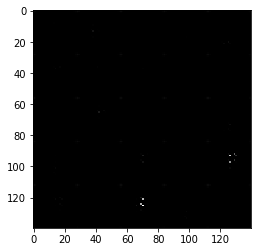

Epoch 1/2... Discriminator Loss: 0.7181... Generator Loss: 2.4938 Sum Loss: 3.2119
Epoch 1/2... Discriminator Loss: 0.6650... Generator Loss: 1.4677 Sum Loss: 2.1327
Epoch 1/2... Discriminator Loss: 0.7645... Generator Loss: 1.9845 Sum Loss: 2.7489
Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 2.3323 Sum Loss: 3.2257
Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 1.3167 Sum Loss: 2.1722
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 2.1228 Sum Loss: 3.4534
Epoch 1/2... Discriminator Loss: 1.4808... Generator Loss: 2.2982 Sum Loss: 3.7790
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 1.2101 Sum Loss: 2.2460
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 1.3373 Sum Loss: 2.3298
Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 0.6469 Sum Loss: 1.8278


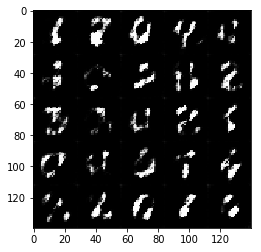

Epoch 1/2... Discriminator Loss: 1.1686... Generator Loss: 1.7606 Sum Loss: 2.9292
Epoch 1/2... Discriminator Loss: 1.5802... Generator Loss: 0.5626 Sum Loss: 2.1428
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.7263 Sum Loss: 2.1557
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.7000 Sum Loss: 2.1485
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 1.7359 Sum Loss: 3.1619
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.9637 Sum Loss: 2.4143
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 0.8537 Sum Loss: 2.0647
Epoch 1/2... Discriminator Loss: 1.7284... Generator Loss: 1.5676 Sum Loss: 3.2959
Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 0.5290 Sum Loss: 1.9777
Epoch 1/2... Discriminator Loss: 1.5323... Generator Loss: 1.6787 Sum Loss: 3.2110


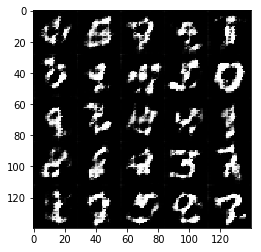

Epoch 1/2... Discriminator Loss: 1.1932... Generator Loss: 1.0153 Sum Loss: 2.2084
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.5621 Sum Loss: 2.0899
Epoch 1/2... Discriminator Loss: 1.4981... Generator Loss: 0.5538 Sum Loss: 2.0519
Epoch 1/2... Discriminator Loss: 1.5731... Generator Loss: 0.4523 Sum Loss: 2.0254
Epoch 1/2... Discriminator Loss: 1.2512... Generator Loss: 1.1254 Sum Loss: 2.3766
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 1.0859 Sum Loss: 2.2808
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 1.4448 Sum Loss: 2.7483
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.8455 Sum Loss: 2.1888
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 1.1215 Sum Loss: 2.3649
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.6606 Sum Loss: 2.0572


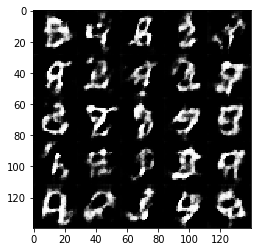

Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 0.8742 Sum Loss: 2.0290
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 1.0121 Sum Loss: 2.2435
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.9145 Sum Loss: 2.1624
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 1.0825 Sum Loss: 2.3390
Epoch 1/2... Discriminator Loss: 1.3685... Generator Loss: 0.5555 Sum Loss: 1.9240
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 1.0668 Sum Loss: 2.3155
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.8165 Sum Loss: 2.0701
Epoch 1/2... Discriminator Loss: 1.1617... Generator Loss: 1.0200 Sum Loss: 2.1817
Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 0.6435 Sum Loss: 1.9508
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.8598 Sum Loss: 2.0687


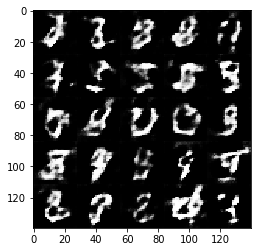

Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 0.9787 Sum Loss: 2.1635
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 1.0496 Sum Loss: 2.1896
Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 0.9982 Sum Loss: 2.1794
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 0.9113 Sum Loss: 2.1324
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 1.2589 Sum Loss: 2.5806
Epoch 1/2... Discriminator Loss: 1.2376... Generator Loss: 0.8934 Sum Loss: 2.1310
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 1.1392 Sum Loss: 2.2889
Epoch 1/2... Discriminator Loss: 1.1783... Generator Loss: 1.0013 Sum Loss: 2.1796
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 1.0186 Sum Loss: 2.2007
Epoch 1/2... Discriminator Loss: 1.2820... Generator Loss: 1.1740 Sum Loss: 2.4560


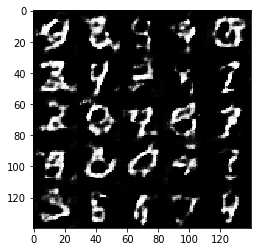

Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 1.0147 Sum Loss: 2.2121
Epoch 1/2... Discriminator Loss: 1.1372... Generator Loss: 1.1224 Sum Loss: 2.2597
Epoch 1/2... Discriminator Loss: 1.1454... Generator Loss: 1.1233 Sum Loss: 2.2686
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 0.6642 Sum Loss: 1.9924
Epoch 1/2... Discriminator Loss: 1.2263... Generator Loss: 1.3454 Sum Loss: 2.5716
Epoch 1/2... Discriminator Loss: 1.1937... Generator Loss: 1.1302 Sum Loss: 2.3239
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.7528 Sum Loss: 2.0513
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 1.0530 Sum Loss: 2.2799
Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 0.9502 Sum Loss: 2.1225
Epoch 1/2... Discriminator Loss: 1.2278... Generator Loss: 0.8060 Sum Loss: 2.0338


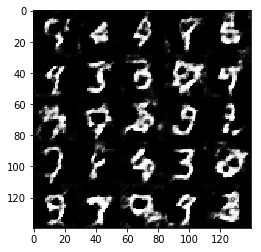

Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 0.9296 Sum Loss: 2.1177
Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 0.7067 Sum Loss: 1.9813
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 1.0242 Sum Loss: 2.2372
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 0.9476 Sum Loss: 2.1808
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 0.8462 Sum Loss: 2.0723
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 1.1502 Sum Loss: 2.3862
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 0.9548 Sum Loss: 2.1471
Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 0.9275 Sum Loss: 2.1891
Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 0.9002 Sum Loss: 2.1456
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.9996 Sum Loss: 2.2874


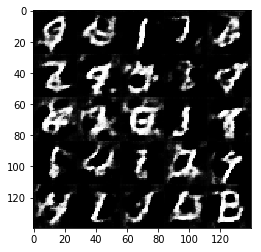

Epoch 1/2... Discriminator Loss: 1.2651... Generator Loss: 1.0359 Sum Loss: 2.3010
Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 1.1276 Sum Loss: 2.3145
Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 0.8878 Sum Loss: 2.1385
Epoch 2/2... Discriminator Loss: 1.2631... Generator Loss: 1.1134 Sum Loss: 2.3765
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 0.8732 Sum Loss: 2.0413
Epoch 2/2... Discriminator Loss: 1.3120... Generator Loss: 1.2247 Sum Loss: 2.5366
Epoch 2/2... Discriminator Loss: 1.1570... Generator Loss: 0.7902 Sum Loss: 1.9472
Epoch 2/2... Discriminator Loss: 1.2956... Generator Loss: 0.9899 Sum Loss: 2.2855
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 1.2826 Sum Loss: 2.6805
Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 1.1349 Sum Loss: 2.4042


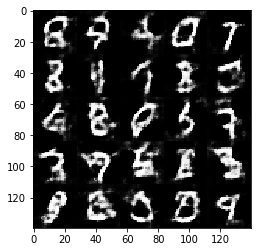

Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 1.0307 Sum Loss: 2.3275
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 1.3080 Sum Loss: 2.7070
Epoch 2/2... Discriminator Loss: 1.2748... Generator Loss: 0.6879 Sum Loss: 1.9627
Epoch 2/2... Discriminator Loss: 1.2940... Generator Loss: 0.8167 Sum Loss: 2.1107
Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 1.0489 Sum Loss: 2.3538
Epoch 2/2... Discriminator Loss: 1.2655... Generator Loss: 0.7325 Sum Loss: 1.9980
Epoch 2/2... Discriminator Loss: 1.3297... Generator Loss: 0.9485 Sum Loss: 2.2783
Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 1.1083 Sum Loss: 2.3315
Epoch 2/2... Discriminator Loss: 1.2575... Generator Loss: 1.2038 Sum Loss: 2.4612
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 0.9734 Sum Loss: 2.2707


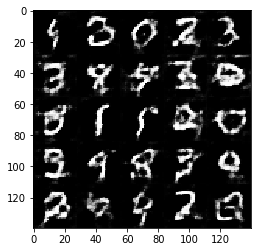

Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 1.4131 Sum Loss: 2.7209
Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 0.6384 Sum Loss: 2.0037
Epoch 2/2... Discriminator Loss: 1.3409... Generator Loss: 0.7798 Sum Loss: 2.1208
Epoch 2/2... Discriminator Loss: 1.1919... Generator Loss: 1.0483 Sum Loss: 2.2402
Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 1.1069 Sum Loss: 2.4201
Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.7147 Sum Loss: 2.0796
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 1.1529 Sum Loss: 2.4541
Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.9002 Sum Loss: 2.1685
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 1.2609 Sum Loss: 2.5044
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 0.8347 Sum Loss: 2.0425


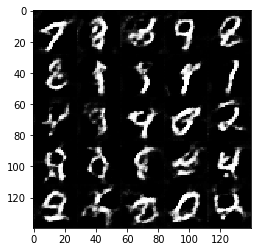

Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 1.1453 Sum Loss: 2.3746
Epoch 2/2... Discriminator Loss: 1.2821... Generator Loss: 0.8150 Sum Loss: 2.0971
Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 0.8869 Sum Loss: 2.1934
Epoch 2/2... Discriminator Loss: 1.2722... Generator Loss: 0.7057 Sum Loss: 1.9778
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 1.0409 Sum Loss: 2.3637
Epoch 2/2... Discriminator Loss: 1.2910... Generator Loss: 0.7956 Sum Loss: 2.0866
Epoch 2/2... Discriminator Loss: 1.1728... Generator Loss: 1.1559 Sum Loss: 2.3288
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 1.2968 Sum Loss: 2.6142
Epoch 2/2... Discriminator Loss: 1.2167... Generator Loss: 0.8482 Sum Loss: 2.0649
Epoch 2/2... Discriminator Loss: 1.4071... Generator Loss: 0.6030 Sum Loss: 2.0101


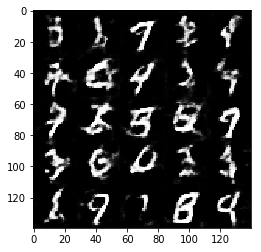

Epoch 2/2... Discriminator Loss: 1.2938... Generator Loss: 0.8054 Sum Loss: 2.0991
Epoch 2/2... Discriminator Loss: 1.2190... Generator Loss: 0.8519 Sum Loss: 2.0710
Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.7676 Sum Loss: 2.0067
Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 1.2282 Sum Loss: 2.6049
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.9948 Sum Loss: 2.2747
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 1.0770 Sum Loss: 2.3877
Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 1.1203 Sum Loss: 2.4840
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.8495 Sum Loss: 2.1115
Epoch 2/2... Discriminator Loss: 1.1734... Generator Loss: 1.0021 Sum Loss: 2.1755
Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 0.9963 Sum Loss: 2.3399


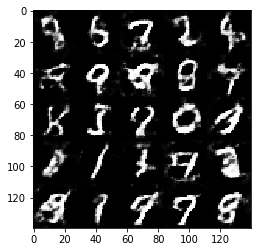

Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 1.1016 Sum Loss: 2.3602
Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 1.1286 Sum Loss: 2.3170
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 0.7716 Sum Loss: 2.0142
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.9065 Sum Loss: 2.1500
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.7914 Sum Loss: 2.0422
Epoch 2/2... Discriminator Loss: 1.3031... Generator Loss: 1.2618 Sum Loss: 2.5650
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 0.8264 Sum Loss: 2.0877
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.9211 Sum Loss: 2.1391
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 0.8380 Sum Loss: 2.0831
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 0.8232 Sum Loss: 2.0890


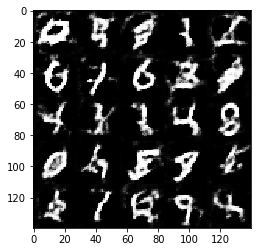

Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 0.9934 Sum Loss: 2.3322
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 0.9077 Sum Loss: 2.1248
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.7084 Sum Loss: 2.0191
Epoch 2/2... Discriminator Loss: 1.3244... Generator Loss: 1.2211 Sum Loss: 2.5455
Epoch 2/2... Discriminator Loss: 1.2343... Generator Loss: 1.0105 Sum Loss: 2.2448
Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 1.0986 Sum Loss: 2.3137
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 1.3951 Sum Loss: 2.7132
Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 1.0605 Sum Loss: 2.3141
Epoch 2/2... Discriminator Loss: 1.2701... Generator Loss: 0.9311 Sum Loss: 2.2012
Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.8149 Sum Loss: 2.1236


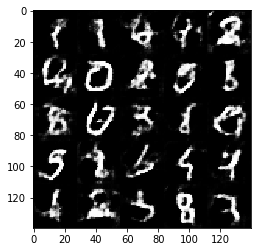

Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.8506 Sum Loss: 2.1536
Epoch 2/2... Discriminator Loss: 1.3458... Generator Loss: 1.2218 Sum Loss: 2.5676
Epoch 2/2... Discriminator Loss: 1.2699... Generator Loss: 0.8370 Sum Loss: 2.1069
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.9881 Sum Loss: 2.3365
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.8000 Sum Loss: 2.0539
Epoch 2/2... Discriminator Loss: 1.2545... Generator Loss: 0.8209 Sum Loss: 2.0754
Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 0.9239 Sum Loss: 2.2031
Epoch 2/2... Discriminator Loss: 1.2655... Generator Loss: 0.7829 Sum Loss: 2.0484
Epoch 2/2... Discriminator Loss: 1.2957... Generator Loss: 0.7675 Sum Loss: 2.0632
Epoch 2/2... Discriminator Loss: 1.2073... Generator Loss: 0.8415 Sum Loss: 2.0488


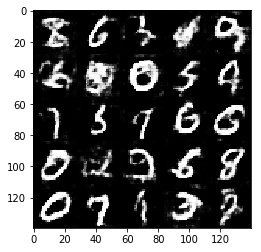

Epoch 2/2... Discriminator Loss: 1.3067... Generator Loss: 1.1621 Sum Loss: 2.4688
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 0.9345 Sum Loss: 2.2020
Epoch 2/2... Discriminator Loss: 1.2525... Generator Loss: 0.8879 Sum Loss: 2.1404
Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 0.8096 Sum Loss: 2.0976
Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 0.7578 Sum Loss: 2.1135
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.8411 Sum Loss: 2.1547
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 0.7902 Sum Loss: 2.0911
Epoch 2/2... Discriminator Loss: 1.2915... Generator Loss: 1.0232 Sum Loss: 2.3147
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 0.7981 Sum Loss: 2.0843
Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.8881 Sum Loss: 2.1625


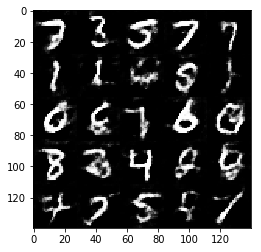

Epoch 2/2... Discriminator Loss: 1.2571... Generator Loss: 1.1039 Sum Loss: 2.3610
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.9651 Sum Loss: 2.2098
Epoch 2/2... Discriminator Loss: 1.3591... Generator Loss: 0.7151 Sum Loss: 2.0741
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.9362 Sum Loss: 2.2589
Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.8632 Sum Loss: 2.1201
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 1.2412 Sum Loss: 2.2730
Epoch 2/2... Discriminator Loss: 1.0542... Generator Loss: 1.6199 Sum Loss: 2.6741


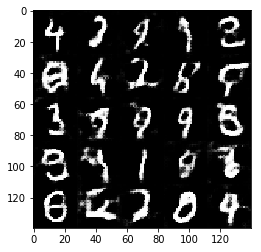

In [75]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.9340 Sum Loss: 2.6927
Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 1.2048 Sum Loss: 1.7251
Epoch 1/1... Discriminator Loss: 0.1891... Generator Loss: 8.0725 Sum Loss: 8.2616
Epoch 1/1... Discriminator Loss: 0.4497... Generator Loss: 12.0599 Sum Loss: 12.5096
Epoch 1/1... Discriminator Loss: 0.2392... Generator Loss: 4.5383 Sum Loss: 4.7776
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 4.0916 Sum Loss: 4.5029
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 4.0637 Sum Loss: 4.4684
Epoch 1/1... Discriminator Loss: 0.2806... Generator Loss: 3.9422 Sum Loss: 4.2229
Epoch 1/1... Discriminator Loss: 0.1340... Generator Loss: 5.4399 Sum Loss: 5.5739
Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 4.7606 Sum Loss: 5.1630


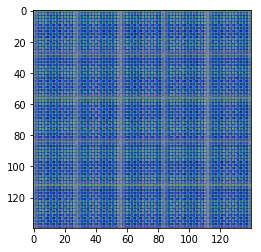

Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 6.0356 Sum Loss: 6.7865
Epoch 1/1... Discriminator Loss: 0.2143... Generator Loss: 8.8913 Sum Loss: 9.1056
Epoch 1/1... Discriminator Loss: 1.9400... Generator Loss: 10.3677 Sum Loss: 12.3077
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.1668 Sum Loss: 2.1333
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.9539 Sum Loss: 2.1640
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.5629 Sum Loss: 2.4025
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 2.1770 Sum Loss: 3.2156
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.3826 Sum Loss: 2.1969
Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 2.0392 Sum Loss: 2.7717
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 0.9729 Sum Loss: 1.8510


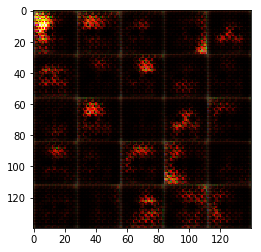

Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 2.2341 Sum Loss: 2.7945
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 3.1137 Sum Loss: 3.7965
Epoch 1/1... Discriminator Loss: 0.6880... Generator Loss: 1.7588 Sum Loss: 2.4468
Epoch 1/1... Discriminator Loss: 0.3673... Generator Loss: 2.2909 Sum Loss: 2.6582
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 2.3694 Sum Loss: 2.9555
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 2.8090 Sum Loss: 3.3843
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.4703 Sum Loss: 2.1366
Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 4.2545 Sum Loss: 4.7672
Epoch 1/1... Discriminator Loss: 0.2906... Generator Loss: 2.0845 Sum Loss: 2.3751
Epoch 1/1... Discriminator Loss: 0.4730... Generator Loss: 3.7790 Sum Loss: 4.2519


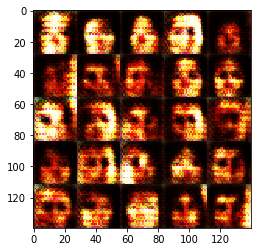

Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 3.2062 Sum Loss: 3.6338
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 3.9371 Sum Loss: 4.4566
Epoch 1/1... Discriminator Loss: 0.2255... Generator Loss: 2.6259 Sum Loss: 2.8513
Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 1.8912 Sum Loss: 2.4198
Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 1.0906 Sum Loss: 1.7713
Epoch 1/1... Discriminator Loss: 0.6613... Generator Loss: 2.1205 Sum Loss: 2.7818
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 1.2306 Sum Loss: 1.8895
Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 2.0771 Sum Loss: 2.5138
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 4.3490 Sum Loss: 5.4455
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 2.5197 Sum Loss: 3.0073


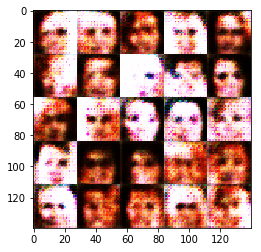

Epoch 1/1... Discriminator Loss: 0.5856... Generator Loss: 1.9573 Sum Loss: 2.5430
Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 3.2232 Sum Loss: 4.0702
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 0.7506 Sum Loss: 1.7258
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 1.5667 Sum Loss: 2.1497
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.5059 Sum Loss: 1.9657
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 1.1183 Sum Loss: 1.9353
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 2.5325 Sum Loss: 3.5497
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 2.1204 Sum Loss: 2.7651
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 1.9132 Sum Loss: 2.8285
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 3.8702 Sum Loss: 5.0837


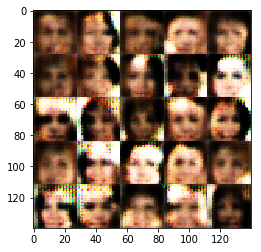

Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 2.1980 Sum Loss: 2.9515
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.0475 Sum Loss: 2.1137
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 0.8260 Sum Loss: 1.7212
Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 1.6457 Sum Loss: 2.3094
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.8412 Sum Loss: 1.9347
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 1.2447 Sum Loss: 2.1797
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.1109 Sum Loss: 1.9382
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 3.2278 Sum Loss: 3.8575
Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 2.4122 Sum Loss: 2.9604
Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 1.9999 Sum Loss: 2.6303


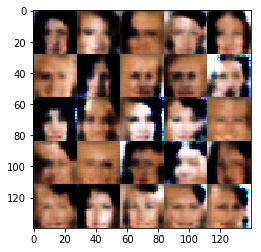

Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 2.1826 Sum Loss: 2.8710
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.3237 Sum Loss: 2.1128
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.7969 Sum Loss: 2.5821
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.8689 Sum Loss: 1.9130
Epoch 1/1... Discriminator Loss: 0.5682... Generator Loss: 2.4916 Sum Loss: 3.0599
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 2.0044 Sum Loss: 2.9504
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.9474 Sum Loss: 2.8004
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 2.2976 Sum Loss: 3.5389
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.9857 Sum Loss: 1.9845
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.5671 Sum Loss: 2.4753


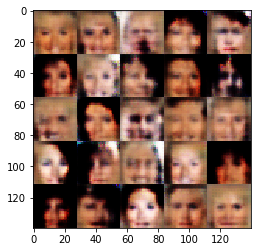

Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 1.7463 Sum Loss: 3.2028
Epoch 1/1... Discriminator Loss: 0.7273... Generator Loss: 1.6863 Sum Loss: 2.4136
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 1.9596 Sum Loss: 3.3338
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.7831 Sum Loss: 1.8933
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 1.1699 Sum Loss: 2.3823
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.4948 Sum Loss: 2.6802
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 1.2582 Sum Loss: 2.3309
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.7682 Sum Loss: 2.7459
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 1.8801 Sum Loss: 3.2346
Epoch 1/1... Discriminator Loss: 0.4528... Generator Loss: 3.8727 Sum Loss: 4.3255


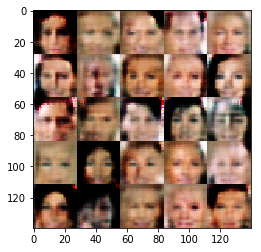

Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.0337 Sum Loss: 2.1185
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.2035 Sum Loss: 1.9293
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.7069 Sum Loss: 1.8391
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 2.1475 Sum Loss: 2.8191
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.6439 Sum Loss: 2.7540
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.4656 Sum Loss: 1.8369
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7172 Sum Loss: 1.9524
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.3224 Sum Loss: 2.3581
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 2.0192 Sum Loss: 3.2714
Epoch 1/1... Discriminator Loss: 1.7414... Generator Loss: 0.4118 Sum Loss: 2.1532


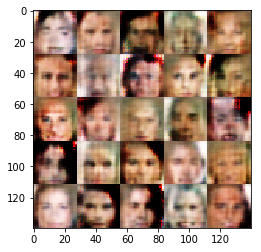

Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.3141 Sum Loss: 2.3445
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.5521 Sum Loss: 1.8420
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 2.4877 Sum Loss: 3.9284
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.8591 Sum Loss: 2.0219
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 1.1463 Sum Loss: 2.4107
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 1.4658 Sum Loss: 2.8699
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.9923 Sum Loss: 2.0813
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.9780 Sum Loss: 2.0804
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 1.3705 Sum Loss: 2.4763
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.3368 Sum Loss: 2.3528


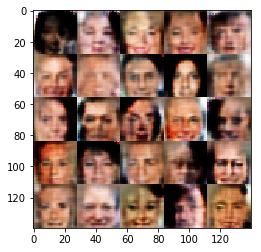

Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.7585 Sum Loss: 2.5338
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.6062 Sum Loss: 2.4017
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.8015 Sum Loss: 1.7834
Epoch 1/1... Discriminator Loss: 2.7691... Generator Loss: 3.0212 Sum Loss: 5.7904
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 1.4414 Sum Loss: 2.6157
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 2.3609 Sum Loss: 3.7100
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 1.3190 Sum Loss: 2.5922
Epoch 1/1... Discriminator Loss: 1.9070... Generator Loss: 2.0337 Sum Loss: 3.9407
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 2.2556 Sum Loss: 2.9669
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 2.5953 Sum Loss: 3.4651


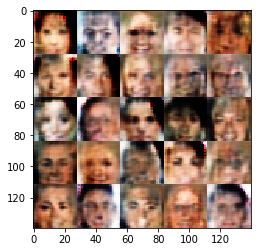

Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.3409 Sum Loss: 2.4502
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.7756 Sum Loss: 2.8373
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 2.7325 Sum Loss: 3.3349
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 1.7026 Sum Loss: 3.0649
Epoch 1/1... Discriminator Loss: 2.3701... Generator Loss: 0.2343 Sum Loss: 2.6044
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 0.7106 Sum Loss: 1.7173
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.5145 Sum Loss: 2.5535
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.1781 Sum Loss: 2.0828
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.8884 Sum Loss: 2.2955
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 1.3435 Sum Loss: 2.6188


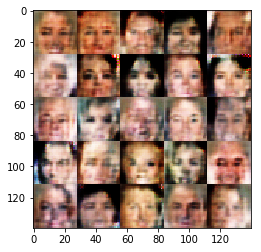

Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 1.0849 Sum Loss: 2.2311
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 1.5253 Sum Loss: 2.7866
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.8880 Sum Loss: 2.9489
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.8541 Sum Loss: 1.9942
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.9427 Sum Loss: 2.1020
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 2.9907 Sum Loss: 3.7330
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 2.0422 Sum Loss: 3.1043
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.0030 Sum Loss: 2.0356
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 0.9984 Sum Loss: 1.9512
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.1596 Sum Loss: 2.2244


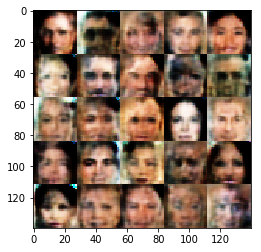

Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 1.7250 Sum Loss: 2.9495
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.0471 Sum Loss: 2.1810
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.5325 Sum Loss: 1.9746
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 1.1774 Sum Loss: 2.2373
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 1.8324 Sum Loss: 2.9317
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.8836 Sum Loss: 2.0189
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 1.7682 Sum Loss: 3.1508
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.8929 Sum Loss: 2.7309
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 1.4192 Sum Loss: 2.3017
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 2.1565 Sum Loss: 2.9545


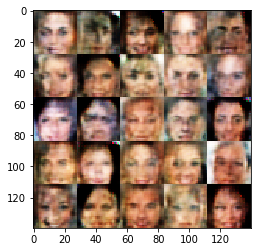

Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.7055 Sum Loss: 1.8592
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.7423 Sum Loss: 1.8787
Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 1.2096 Sum Loss: 2.0264
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.9067 Sum Loss: 2.1731
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.0461 Sum Loss: 2.0594
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 2.5122 Sum Loss: 3.9622
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.6556 Sum Loss: 1.9271
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.3226 Sum Loss: 2.3264
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.7754 Sum Loss: 1.9343
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.5126 Sum Loss: 2.5898


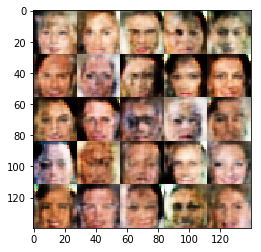

Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.9296 Sum Loss: 2.1361
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 3.3030 Sum Loss: 4.1637
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 2.0345 Sum Loss: 2.7474
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.3536 Sum Loss: 2.4299
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.8257 Sum Loss: 2.6650
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.0302 Sum Loss: 2.1899
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.4912 Sum Loss: 2.3442
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.8286 Sum Loss: 2.0115
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 1.0493 Sum Loss: 2.1886
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 1.2080 Sum Loss: 2.4122


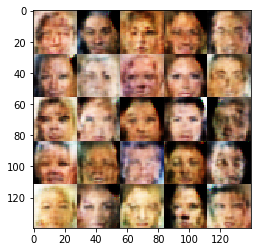

Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.0544 Sum Loss: 1.9900
Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 1.8193 Sum Loss: 2.5229
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.1589 Sum Loss: 2.2338
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.3744 Sum Loss: 2.4266
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 1.6423 Sum Loss: 3.0890
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 1.1887 Sum Loss: 2.4420
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 1.0994 Sum Loss: 2.2792
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.7565 Sum Loss: 2.7123
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.1104 Sum Loss: 2.0686
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 4.0967 Sum Loss: 4.7443


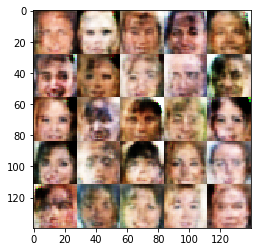

Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 1.0900 Sum Loss: 2.3129
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6828 Sum Loss: 2.1107
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.0716 Sum Loss: 2.1587
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.9946 Sum Loss: 2.2158
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 3.6452 Sum Loss: 4.8342
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.7769 Sum Loss: 2.0671
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.7684 Sum Loss: 2.0078
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.9616 Sum Loss: 1.9656
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.2852 Sum Loss: 2.4694
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8461 Sum Loss: 2.1670


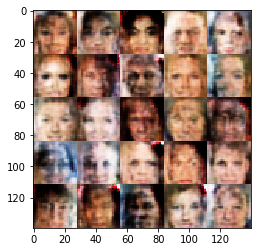

Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.8829 Sum Loss: 2.2374
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 1.1957 Sum Loss: 2.3468
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 1.1553 Sum Loss: 2.5730
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.8532 Sum Loss: 1.9783
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 1.2269 Sum Loss: 2.4901
Epoch 1/1... Discriminator Loss: 1.6701... Generator Loss: 0.4451 Sum Loss: 2.1152
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.1753 Sum Loss: 2.1657
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.8692 Sum Loss: 2.0298
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.9654 Sum Loss: 2.7944
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.8771 Sum Loss: 2.0295


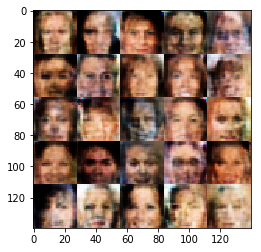

Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 1.5737 Sum Loss: 2.9199
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.2253 Sum Loss: 2.2578
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 1.9261 Sum Loss: 3.3301
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.9990 Sum Loss: 2.2187
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 1.1205 Sum Loss: 2.1480
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.3426 Sum Loss: 2.4262
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.6072 Sum Loss: 2.7068
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.9057 Sum Loss: 1.8952
Epoch 1/1... Discriminator Loss: 0.5251... Generator Loss: 2.5901 Sum Loss: 3.1153
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.7369 Sum Loss: 2.6650


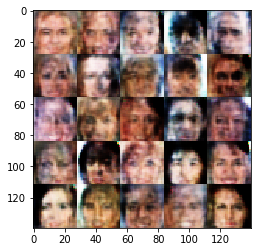

Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.6642 Sum Loss: 1.9693
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 1.2226 Sum Loss: 2.4074
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.2151 Sum Loss: 2.3489
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 1.7131 Sum Loss: 2.6442
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.7954 Sum Loss: 2.6899
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.6591 Sum Loss: 2.7309
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.7033 Sum Loss: 1.8175
Epoch 1/1... Discriminator Loss: 1.6138... Generator Loss: 0.5848 Sum Loss: 2.1987
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.8734 Sum Loss: 2.1669
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.5491 Sum Loss: 1.9019


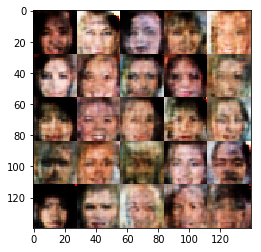

Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.6978 Sum Loss: 2.0165
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.7861 Sum Loss: 2.5512
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.1770 Sum Loss: 2.2883
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.8924 Sum Loss: 2.1507
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.7326 Sum Loss: 1.8971
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.1064 Sum Loss: 2.3008
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 2.4331 Sum Loss: 3.4869
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.7435 Sum Loss: 1.9923
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.6170 Sum Loss: 1.8973
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.0795 Sum Loss: 2.0385


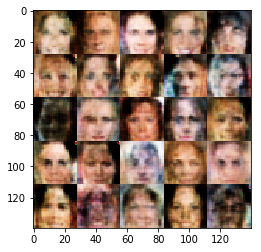

Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 1.4502 Sum Loss: 2.7194
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 1.0802 Sum Loss: 2.2254
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.8522 Sum Loss: 2.0406
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.7468 Sum Loss: 2.5469
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.9235 Sum Loss: 2.0827
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.3615 Sum Loss: 2.5591
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.9681 Sum Loss: 2.2334
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.9255 Sum Loss: 2.0455
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.7594 Sum Loss: 1.8895
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.4078 Sum Loss: 2.6762


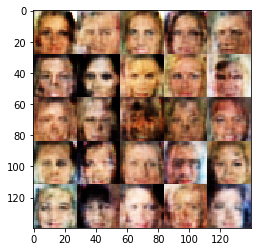

Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 1.1876 Sum Loss: 2.3727
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.9592 Sum Loss: 3.1002
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 1.2315 Sum Loss: 2.4745
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.8041 Sum Loss: 2.8577
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 1.6001 Sum Loss: 3.0530
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.7361 Sum Loss: 1.8677
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.2268 Sum Loss: 2.2436
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.9468 Sum Loss: 2.1345
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 1.1476 Sum Loss: 2.3176
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.7319 Sum Loss: 1.9146


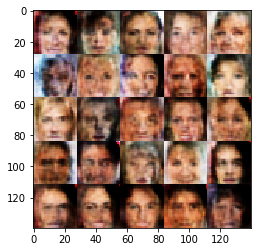

Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.0622 Sum Loss: 2.0569
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 1.4137 Sum Loss: 2.6839
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.4138 Sum Loss: 2.3280
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 1.2516 Sum Loss: 2.4849
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 1.4745 Sum Loss: 2.8654
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.0670 Sum Loss: 2.2269
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 1.5825 Sum Loss: 3.2065
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.9770 Sum Loss: 3.0290
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.7170 Sum Loss: 1.9336
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.4479 Sum Loss: 2.6369


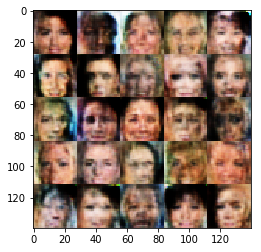

Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.1025 Sum Loss: 2.1722
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 1.5500 Sum Loss: 2.6835
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 1.3510 Sum Loss: 2.6123
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 1.3026 Sum Loss: 2.3765
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.6348 Sum Loss: 1.9238
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.5729 Sum Loss: 2.0404
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.3506 Sum Loss: 2.3602
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.8387 Sum Loss: 2.0592
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.7796 Sum Loss: 1.9845
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 1.0554 Sum Loss: 2.4843


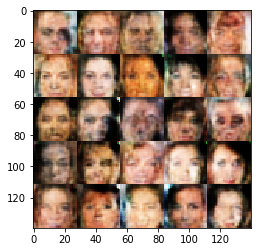

Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.4193 Sum Loss: 2.5344
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.0327 Sum Loss: 2.1035
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 1.7300 Sum Loss: 3.0113
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.9130 Sum Loss: 1.9666
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.0744 Sum Loss: 2.1891
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 1.5281 Sum Loss: 2.6925
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.2488 Sum Loss: 2.1815
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 1.0817 Sum Loss: 2.1948
Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 1.2971 Sum Loss: 2.0939
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.5740 Sum Loss: 2.6424


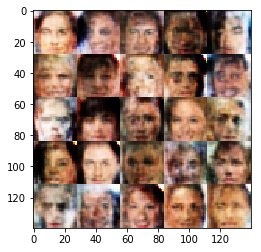

Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.5937 Sum Loss: 2.7745
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.0640 Sum Loss: 2.0614
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.7593 Sum Loss: 2.9647
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 1.4439 Sum Loss: 2.7341
Epoch 1/1... Discriminator Loss: 0.6399... Generator Loss: 2.0715 Sum Loss: 2.7114
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.1296 Sum Loss: 2.2640
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.9042 Sum Loss: 2.0290
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.8283 Sum Loss: 2.0953
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 1.3310 Sum Loss: 2.5626
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.2673 Sum Loss: 2.3301


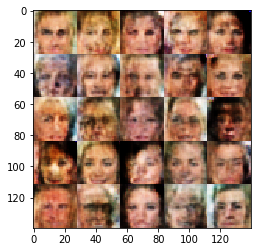

Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.8347 Sum Loss: 2.0515
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.9882 Sum Loss: 2.0889
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.4218 Sum Loss: 2.5105
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.4461 Sum Loss: 2.2546
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.7221 Sum Loss: 1.8771
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 1.2919 Sum Loss: 2.5093
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 1.7052 Sum Loss: 3.0292
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.2251 Sum Loss: 2.2523
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.9927 Sum Loss: 2.1140
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.7430 Sum Loss: 1.9510


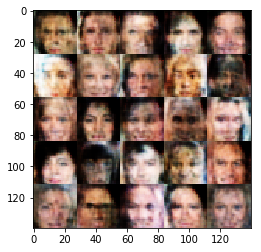

Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 1.2282 Sum Loss: 2.4795
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.2046 Sum Loss: 2.3457
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 1.0757 Sum Loss: 2.2642
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.9013 Sum Loss: 2.0813
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.8129 Sum Loss: 3.0620
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.8615 Sum Loss: 1.9527
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.7783 Sum Loss: 2.0007
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 1.4808 Sum Loss: 2.7288
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.9339 Sum Loss: 2.1393
Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.5207 Sum Loss: 2.0919


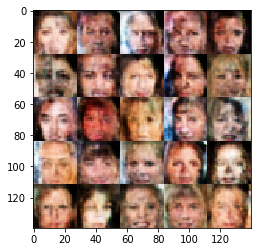

Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.9372 Sum Loss: 2.7145
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.9129 Sum Loss: 2.1358
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 1.5896 Sum Loss: 2.8338
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.4164 Sum Loss: 2.4485
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.9852 Sum Loss: 2.1559
Epoch 1/1... Discriminator Loss: 1.9162... Generator Loss: 2.3615 Sum Loss: 4.2777
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.8767 Sum Loss: 2.1242
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.8246 Sum Loss: 1.9798
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6037 Sum Loss: 2.0547
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.0697 Sum Loss: 2.0647


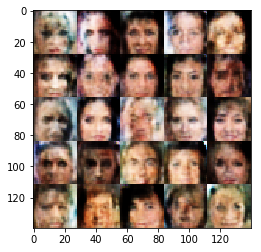

Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.3288 Sum Loss: 2.3357
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 1.3188 Sum Loss: 2.5657
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.4769 Sum Loss: 1.9076
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.9273 Sum Loss: 2.0665
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 1.0566 Sum Loss: 2.4792
Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 2.0603 Sum Loss: 2.6693


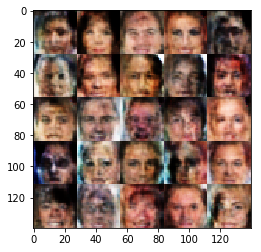

In [76]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.